In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset directly from the URL
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(url)

# Check the shape and basic info
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Check for missing values
missing = df.isnull().sum()
print("\nMissing values per column:")
print(missing[missing > 0])

# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':  # Categorical
        df[col] = df[col].fillna('NA')
    else:  # Numerical
        df[col] = df[col].fillna(0.0)

# Confirm no missing values left
print("\nMissing values after handling:")
print(df.isnull().sum().sum())

# Split the data: train (60%), then val/test (20% each from full)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 of 80% = 20% of full

# Check shapes and target balance
print("\nSplits shapes:", df_train.shape, df_val.shape, df_test.shape)
print("Target balance in train (converted=1 rate):", df_train['converted'].mean())


Dataset shape: (1462, 9)

First few rows:
    lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1  

Missing values per column:
lead_source          12

In [12]:
df.head()   

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [13]:
# QUESTION 1

from sklearn.metrics import roc_auc_score

# Target from train
y_train = df_train['converted'].values

# Numerical features to evaluate
features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

# Dictionary to store AUCs
auc_scores = {}

for feature in features:
    # Use the feature as "prediction scores"
    scores = df_train[feature].values
    
    # Compute initial AUC
    auc = roc_auc_score(y_train, scores)
    
    # If AUC < 0.5, negate to improve correlation
    if auc < 0.5:
        scores = -scores
        auc = roc_auc_score(y_train, scores)
    
    # Store the final AUC (after possible negation)
    auc_scores[feature] = auc
    print(f"{feature}: AUC = {auc:.3f}")

# Find the highest AUC feature
best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nHighest AUC feature: {best_feature} with AUC = {auc_scores[best_feature]:.3f}")


lead_score: AUC = 0.614
number_of_courses_viewed: AUC = 0.764
interaction_count: AUC = 0.738
annual_income: AUC = 0.552

Highest AUC feature: number_of_courses_viewed with AUC = 0.764


In [14]:
# QUESTION 2

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# List of categorical and numerical features
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

# Prepare dictionaries for DictVectorizer
def prepare_dict(df):
    return df[categorical + numerical].to_dict(orient='records')

# One-hot encode and vectorize
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(prepare_dict(df_train))
X_val = dv.transform(prepare_dict(df_val))

y_train = df_train['converted'].values
y_val = df_val['converted'].values

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities for validation set
y_pred = model.predict_proba(X_val)[:, 1]

# Compute ROC AUC
auc = roc_auc_score(y_val, y_pred)
print(f"Validation AUC: {auc:.3f}")


Validation AUC: 0.817


/workspaces/machine-learning-zoomcamp-homework/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspaces/machine-learning-zoomcamp-homework/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspaces/machine-learning-zoomcamp-homework/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

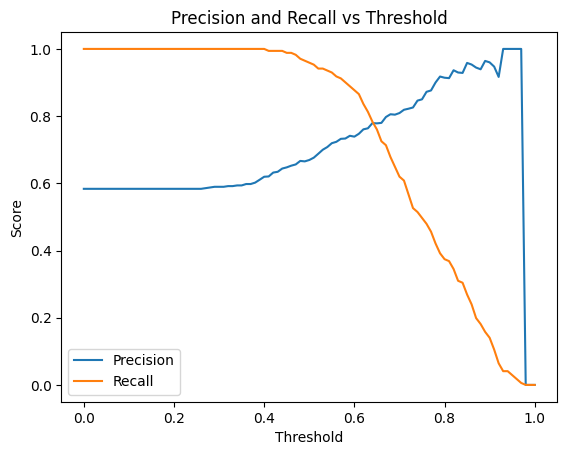

Intersection threshold: 0.980


In [15]:
# QUESTION 3

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Use predicted probabilities from your model
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_bin = (y_pred >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred_bin))
    recalls.append(recall_score(y_val, y_pred_bin))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.show()

# Find intersection threshold
diffs = np.abs(np.array(precisions) - np.array(recalls))
intersection_idx = np.argmin(diffs)
intersection_threshold = thresholds[intersection_idx]
print(f"Intersection threshold: {intersection_threshold:.3f}")


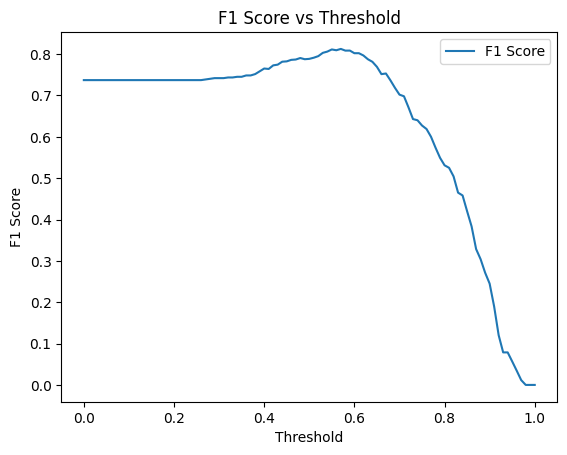

Maximum F1 score: 0.812 at threshold 0.57


In [16]:
# QUESTION 4

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Use the predicted probabilities from your model (y_pred)
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_bin = (y_pred >= t).astype(int)
    f1_scores.append(f1_score(y_val, y_pred_bin))

plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.show()

# Find the index of max F1 score
max_idx = np.argmax(f1_scores)
best_threshold = thresholds[max_idx]
max_f1 = f1_scores[max_idx]
print(f"Maximum F1 score: {max_f1:.3f} at threshold {best_threshold:.2f}")


In [ ]:
# QUESTION 5

from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
features = categorical + numerical

df_full_train = pd.concat([df_train, df_val]) # Use combined train+val for cross-validation
X_full = df_full_train[features]
y_full = df_full_train['converted'].values

kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_cv_train = df_full_train.iloc[train_idx]
    df_cv_val = df_full_train.iloc[val_idx]

    # Prepare: one-hot encoding + numerical
    dv = DictVectorizer(sparse=False)
    X_cv_train = dv.fit_transform(df_cv_train[features].to_dict(orient='records'))
    X_cv_val = dv.transform(df_cv_val[features].to_dict(orient='records'))
    y_cv_train = df_cv_train['converted'].values
    y_cv_val = df_cv_val['converted'].values

    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_cv_train, y_cv_train)
    y_pred = model.predict_proba(X_cv_val)[:, 1]

    # Score
    auc = roc_auc_score(y_cv_val, y_pred)
    auc_scores.append(auc)
    print(f'Fold AUC: {auc:.3f}')

# Calculate mean and standard deviation
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
print(f'Mean AUC: {mean_auc:.3f}')
print(f'Standard deviation: {std_auc:.3f}')


Fold AUC: 0.818
Fold AUC: 0.803
Fold AUC: 0.843
Fold AUC: 0.802
Fold AUC: 0.845
Mean AUC: 0.822
Standard deviation: 0.018


In [18]:
# QUESTION 6

from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
features = categorical + numerical

df_full_train = pd.concat([df_train, df_val])
X_full = df_full_train[features]
y_full = df_full_train['converted'].values

Cs = [0.000001, 0.001, 1]
results = {}

kf = KFold(n_splits=5, shuffle=True, random_state=1)

for C in Cs:
    auc_scores = []
    for train_idx, val_idx in kf.split(df_full_train):
        df_cv_train = df_full_train.iloc[train_idx]
        df_cv_val = df_full_train.iloc[val_idx]

        dv = DictVectorizer(sparse=False)
        X_cv_train = dv.fit_transform(df_cv_train[features].to_dict(orient='records'))
        X_cv_val = dv.transform(df_cv_val[features].to_dict(orient='records'))
        y_cv_train = df_cv_train['converted'].values
        y_cv_val = df_cv_val['converted'].values

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_cv_train, y_cv_train)
        y_pred = model.predict_proba(X_cv_val)[:, 1]

        auc = roc_auc_score(y_cv_val, y_pred)
        auc_scores.append(auc)

    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    results[C] = (round(mean_auc, 3), round(std_auc, 3))
    print(f"C={C}: mean={mean_auc:.3f}, std={std_auc:.3f}")

# Find best C
best_C = max(results.items(), key=lambda x: (x[1][0], -x[1][1], -x[0]))[0]
print(f"Best C: {best_C}")


C=1e-06: mean=0.561, std=0.043
C=0.001: mean=0.867, std=0.015
C=1: mean=0.822, std=0.018
Best C: 0.001
